# 02c — MDS 2D

In [10]:
from pathlib import Path
import pickle, math, random, csv
import matplotlib.pyplot as plt

ROOT=Path.cwd()
for c in (ROOT,*ROOT.parents):
    if (c/"outputs"/"similarity_distance.pkl").exists(): ROOT=c; break
OUT=ROOT/"outputs"
obj=pickle.load(open(OUT/"similarity_distance.pkl","rb"))
langs=obj["langs"]; Dist=obj["Dist"]; n=len(langs)
D2=[[Dist[i][j]**2 for j in range(n)] for i in range(n)]
J=[[ (1.0 if i==j else 0.0)-1/n for j in range(n)] for i in range(n)]
def matmul(A,B): return [[sum(A[i][k]*B[k][j] for k in range(len(B))) for j in range(len(B[0]))] for i in range(len(A))]
B=matmul(J, matmul(D2, J)); B=[[-0.5*x for x in row] for row in B]

### Step 1: Extract top two eigencomponents via power iteration (for 2-D embedding)

This cell computes the first two eigenpairs of a symmetric matrix `B` using **power iteration** and **deflation**, then builds 2-D coordinates:

- `power(M, iters)`: 
  - Starts with a random vector `v` (length `n`) and repeatedly multiplies by `M`, normalizing each step.
  - Returns the dominant eigenvalue `λ₁` and corresponding unit eigenvector `v₁`.

- `deflate(M, lam, v)`:
  - Performs **rank-1 deflation**: `M ← M − λ v vᵀ` so the next call to `power` finds the second eigenpair `(λ₂, v₂)`.

Procedure:
1. Copy `B` into `M` to keep `B` unchanged.
2. Run `power(M)` to get `(λ₁, v₁)`, then deflate `M` by `λ₁ v₁ v₁ᵀ`.
3. Run `power(M)` again to get `(λ₂, v₂)`.

Embedding:
- Form coordinates:
  - `x = √max(λ₁, 0) · v₁`
  - `y = √max(λ₂, 0) · v₂`
- This matches classical MDS/PCA-style scaling so that the variance captured along each axis reflects the corresponding eigenvalue.

Notes:
- Assumes `B` is symmetric (e.g., a centered Gram/similarity matrix).
- Convergence speed depends on the eigengap; increase `iters` if needed.
- Eigenvector signs are arbitrary; flipping `v` doesn’t change geometry.

In [11]:
def power(M, iters=200):
    v=[random.random() for _ in range(n)]
    for _ in range(iters):
        w=[sum(M[i][j]*v[j] for j in range(n)) for i in range(n)]
        nv=(sum(x*x for x in w))**0.5 or 1e-12
        v=[x/nv for x in w]
    lam=sum(v[i]*sum(M[i][j]*v[j] for j in range(n)) for i in range(n))
    return lam, v

def deflate(M, lam, v):
    for i in range(n):
        row=M[i]
        for j in range(n):
            row[j]-=lam*v[i]*v[j]

M=[row[:] for row in B]
lam1,v1=power(M); deflate(M,lam1,v1)
lam2,v2=power(M)

x=[(lam1 if lam1>0 else 0)**0.5*vi for vi in v1]
y=[(lam2 if lam2>0 else 0)**0.5*vj for vj in v2]

### Step 2: Export 2-D embedding and plot the MDS scatter

This cell saves the 2-D coordinates from the eigen-embedding to disk and draws a quick visualization:

- Write `mds.csv` with columns:
  - `lang` — language label  
  - `x`, `y` — 2-D coordinates derived from the top two eigencomponents
- Produce a simple scatter plot:
  - Points at `(x[i], y[i])`
  - Text labels placed at each point for readability
  - Save the figure as `mds.png` in `OUT`

Notes and tips:
- Axes are in an arbitrary rotation/scale; relative geometry matters, not absolute values.
- For less label overlap, consider:
  ```python
  plt.gca().set_aspect("equal", adjustable="datalim")

Saved: d:\OneDrive\Documents\My Learning Resource\University Courses\DLSU\2025-26\T1\CSC715M\assignments\mc01\outputs\mds.csv
Saved: d:\OneDrive\Documents\My Learning Resource\University Courses\DLSU\2025-26\T1\CSC715M\assignments\mc01\outputs\mds_annotated.png


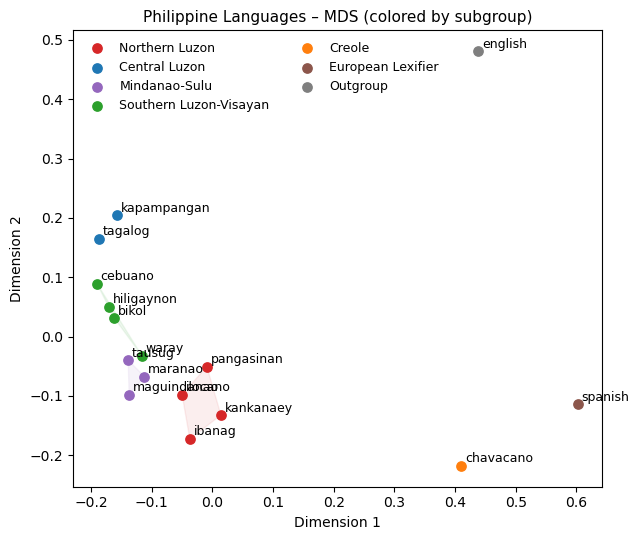

In [12]:
import csv
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# --- 1) Define language → family mapping
FAM = {
    # Central Philippine (Luzon core)
    "tagalog": "Central Luzon",
    "kapampangan": "Central Luzon",

    # Visayan subgroup (Central Philippine)
    "hiligaynon": "Southern Luzon-Visayan",
    "cebuano": "Southern Luzon-Visayan",
    "waray": "Southern Luzon-Visayan",
    "bikol": "Southern Luzon-Visayan",

    # Mindanao–Sulu (Greater Central Philippine)
    "tausug": "Mindanao-Sulu",
    "maguindanao": "Mindanao-Sulu",
    "maranao": "Mindanao-Sulu",

    # Northern Luzon / Cordilleran + Central Luzon
    "ilocano": "Northern Luzon",
    "ibanag": "Northern Luzon",
    "pangasinan": "Northern Luzon",
    "kankanaey": "Northern Luzon",

    # Creole + Lexifiers / Outgroups
    "chavacano": "Creole",
    "spanish": "European Lexifier",
    "english": "Outgroup",
}

# palette per family (feel free to tweak)
FAM_COLOR = {
    "Central Luzon": "#1f77b4",
    "Southern Luzon-Visayan": "#2ca02c",
    "Mindanao-Sulu": "#9467bd",
    "Northern Luzon": "#d62728",
    "Creole": "#ff7f0e",
    "European Lexifier": "#8c564b",
    "Outgroup": "#7f7f7f",
}

# --- 2) Save CSV with family labels ---
OUT = Path(OUT)  # ensure Path
OUT.mkdir(parents=True, exist_ok=True)
with open(OUT / "mds.csv", "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["lang", "x", "y", "family"])
    for i, l in enumerate(langs):
        fam = FAM.get(l.lower(), "Unknown")
        w.writerow([l, x[i], y[i], fam])
print("Saved:", OUT / "mds.csv")

# --- 3) Build family groups for plotting ---
points = {l: (x[i], y[i]) for i, l in enumerate(langs)}
by_family = {}
for l, (xi, yi) in points.items():
    fam = FAM.get(l.lower(), "Unknown")
    by_family.setdefault(fam, []).append((l, xi, yi))

# --- 4) Small convex hull helper (monotonic chain) ---
def convex_hull(pts):
    """pts: list of (x,y). returns hull as list of (x,y) in CCW order."""
    pts = sorted(set(pts))
    if len(pts) <= 2:
        return pts
    def cross(o, a, b):  # 2D cross product
        return (a[0]-o[0])*(b[1]-o[1]) - (a[1]-o[1])*(b[0]-o[0])
    lower = []
    for p in pts:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(p)
    upper = []
    for p in reversed(pts):
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)
    return lower[:-1] + upper[:-1]

# --- 5) Plot ---
plt.figure(figsize=(6.5, 5.5))

# draw family hulls first (so points/labels sit on top)
for fam, rows in by_family.items():
    if fam == "Unknown":
        continue
    xs = [r[1] for r in rows]
    ys = [r[2] for r in rows]
    if len(rows) >= 3:
        hull = convex_hull(list(zip(xs, ys)))
        if len(hull) >= 3:
            poly = Polygon(hull, closed=True, facecolor=FAM_COLOR.get(fam, "#cccccc"),
                           alpha=0.08, edgecolor=FAM_COLOR.get(fam, "#cccccc"), lw=1)
            plt.gca().add_patch(poly)

# plot points by family
for fam, rows in by_family.items():
    xs = [r[1] for r in rows]
    ys = [r[2] for r in rows]
    color = FAM_COLOR.get(fam, "#333333")
    plt.scatter(xs, ys, s=45, color=color, label=fam)

# add labels with a tiny nudge to reduce overlap
nud = 0.006
for l, (xi, yi) in points.items():
    plt.text(xi + nud, yi + nud, l, fontsize=9)

# legend (unique families, no duplicates)
handles, labels = plt.gca().get_legend_handles_labels()
uniq = dict(zip(labels, handles))  # keep last per family; order not guaranteed
plt.legend(uniq.values(), uniq.keys(), frameon=False, fontsize=9, ncol=2, loc="upper left")

plt.title("Philippine Languages – MDS (colored by subgroup)", fontsize=11)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.tight_layout()
plt.savefig(OUT / "mds_annotated.png", dpi=220)
print("Saved:", OUT / "mds_annotated.png")
